In [9]:
# いつも使うやつ
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# pandasで全ての列を表示
pd.options.display.max_columns = None

# 図をipython notebook内で表示
%matplotlib inline

# DeplicatedWarningを避けるため
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)

import sys
sys.path.append('./lib/')

# 交差検定をサクッとやるためのモジュールを読み込む
from sklearn.cross_validation import cross_val_score

# 説明変数つくるための関数
import feature_process_helper

/Users/k.tamashiro/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [92]:
# データをそれぞれ読み込む
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission_df = pd.read_csv('./data/gender_submission.csv')

In [93]:
train = train_df.copy()
test = test_df.copy()

In [94]:
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train['Ticket_Len'] = train['Ticket'].apply(lambda x: len(x))
test['Ticket_Len'] = test['Ticket'].apply(lambda x: len(x))
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])

In [95]:
# 分類モデル（他にもいろいろある）
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [96]:
classifiers = [
    ('lr', LogisticRegression()), 
    ('knn', KNeighborsClassifier()),
    ('linear svc', SVC(kernel="linear")), # データ点が多いと計算に時間がかかる
    ('rbf svc', SVC(gamma=2)), # データ点が多いと計算に時間がかかる
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier(random_state=42)),
    ('et', ExtraTreesClassifier()),
    ('ab', AdaBoostClassifier()),
    ('gbc', GradientBoostingClassifier()),
    ('gnb', GaussianNB()),
    ('lda', LinearDiscriminantAnalysis()),
    ('qda', QuadraticDiscriminantAnalysis()),
    #('xgb', XGBClassifier()) # これだけ個別にインストールする必要があるので今回は割愛
]

In [22]:
warnings.filterwarnings("ignore", category=UserWarning)

import time
results = {}
exec_times = {}

for name, model in classifiers:
    tic = time.time()
    if name in ['linear svc', 'rbf svc']:
        result = cross_val_score(model, train.iloc[:, 2:], train.iloc[:, 1], cv=5, scoring='accuracy')        
    else:
        result = cross_val_score(model, train.iloc[:, 2:], train.iloc[:, 1], cv=5, scoring='log_loss')
    exec_time = time.time() - tic
    exec_times[name] = exec_time
    results[name] = result
    
    print("{0:.3f} ({1:.3f}): time {2:.2f}s, {3}".format(result.mean(), result.std(), exec_time, name))

-0.422 (0.038): time 0.07s, lr
-2.178 (0.569): time 0.05s, knn
0.824 (0.021): time 111.55s, linear svc
0.614 (0.007): time 0.27s, rbf svc
-7.444 (0.591): time 0.05s, dt
-1.437 (0.712): time 0.15s, rf
-2.297 (0.543): time 0.17s, et
-0.669 (0.002): time 0.60s, ab
-0.410 (0.052): time 0.80s, gbc
-3.181 (0.564): time 0.03s, gnb
-0.460 (0.062): time 0.05s, lda
-6.800 (4.199): time 0.05s, qda


In [36]:
pd.DataFrame(results).iloc[0, :].sort_values(ascending=False)

linear svc    0.843575
rbf svc       0.620112
gbc          -0.407247
lr           -0.429545
lda          -0.443265
ab           -0.670160
rf           -1.294756
knn          -2.404539
et           -2.411529
gnb          -3.482638
qda          -4.159571
dt           -8.104070
Name: 0, dtype: float64

SVC(kernel="linear")が一番大きいという認識でおｋ？

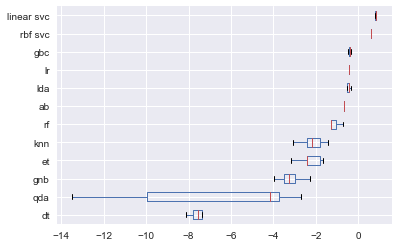

In [23]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 結果の描画を楽にするためpandasのデータフレームに結果を入れる
import pandas as pd

dfr = pd.DataFrame(results)

dfr[dfr.median().sort_values(ascending=True).index].boxplot(vert=False);

見方がわからん

### SVM('linear')

In [97]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
scores = ['accuracy', 'precision', 'recall']

In [98]:
from sklearn.grid_search import GridSearchCV

### 試し学習

In [45]:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [47]:
svc.fit(train.iloc[:, 2:], train.iloc[:, 1])

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [59]:
print(svc.score(train.iloc[:, 2:], train.iloc[:, 1]))

0.83950617284


In [63]:
result = cross_val_score(model, train.iloc[:, 2:], train.iloc[:, 1], cv=5, scoring='accuracy') 

In [64]:
print("{0:.3f} ({1:.3f})".format(result.mean(), result.std()))

0.643 (0.146)


In [84]:
test['Fare'].fillna(train['Fare'].mean(), inplace = True)
predictions = svc.predict(test.iloc[:, 1:])
predictions = pd.DataFrame(predictions, columns=['Survived'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv('y_svc_linear.csv', sep=",", index = False)

kaggleにアップしたら  
0.77990 落ちた